In [2]:
from typing import List, Mapping
from itertools import zip_longest, chain
from glob import iglob
from os.path import basename

import pandas as pd
import numpy as np
from numpy.random import normal, choice, rand
from numpy.polynomial.legendre import Legendre
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
from h5py import File

from vmitools import (
    abel_inverse, finite_legendre_transform_in_theta,
    interp, tohist, transpose_linearly, transpose_to_drdomega, transpose_to_drdth,
    mrot, mhorshear, msqueeze,
)

In [3]:
runs = range(228, 236)
filenames = list(chain.from_iterable(iglob(f"Data/Run_{r:03d}/work/reduced_*.h5") for r in runs))


def read_file(filename):
    with File(filename) as f:
        return {
            # 'delay': f['delay'].value,
            'delay': float(basename(filename)[:-3].split('=')[-1]),
            'df_n': f['df_n'][...],
            'df_img': f['df_img'][...],
        }


many = pd.DataFrame([read_file(fn) for fn in filenames])
many['summed'] = many['df_img'] * many['df_n']
grouped = many.groupby('delay')[['summed', 'df_n']].sum()
df = pd.DataFrame(
    {'df_img': grouped['summed']/grouped['df_n'],
     'df_n': grouped['df_n']}
).reset_index()
df

,delay,df_img,df_n
0,-7.80,"[[0.9626889998752404, 1.033177854064121, 0.923...",3227
1,-7.77,"[[0.6339993247061102, 0.7316705943964479, 0.68...",3249
2,-7.75,"[[0.8669001680100621, 1.1055979328662033, 0.63...",3295
3,-7.72,"[[0.8906436773348787, 0.9035684506616661, 0.69...",3295
4,-7.70,"[[0.869775893397943, 1.7640823743186047, 0.797...",3302
5,-7.67,"[[0.632289479472874, 0.7449557062011252, 0.431...",3165
6,-7.65,"[[0.8097643349223772, 0.9309836010226036, 0.75...",3291
7,-7.62,"[[0.755926993407229, 1.0810564413621933, 0.768...",3252
8,-7.60,"[[0.7969852366241379, 1.2441723879108333, 0.81...",6515
9,-7.57,"[[0.9362663532660491, 1.2410978035017308, 0.83...",3253


In [4]:
zedges = np.arange(-400, 400 + 1)
redges, thedges = np.linspace(0, 400, 801), np.linspace(-np.pi, np.pi, 721)
r = (redges[1:] + redges[:-1]) / 2


def dist(img):
    img = img.T
    xn, yn = img.shape
    xedges = np.arange(xn + 1)
    yedges = np.arange(yn + 1)
    f = interp(img, xedges, yedges)
    g = transpose_linearly(f, np.eye(2), x0=np.array([438, 462]))
    transformed = tohist(g, zedges, zedges)

    dz = zedges[1:] - zedges[:-1]
    inverted = abel_inverse(transformed, zedges) * dz[None, :]  # shape: (r, z)
    sliced = interp(inverted, zedges, zedges)  # (rho, z) -> intensity
    hist_indrdomega = tohist(transpose_to_drdomega(sliced), redges, thedges)  # (r, th) -> intensity
    hist_indrdth = tohist(transpose_to_drdth(sliced), redges, thedges)  # (r, th) -> intensity
    _, coeff, _ = finite_legendre_transform_in_theta(
        hist_indrdomega.sum(0), thedges, 6,
    )  # Shapes of returns: (n, r) (n, r) (n, th)
    return hist_indrdth.sum(1)


df['dist'] = df['df_img'].apply(dist)

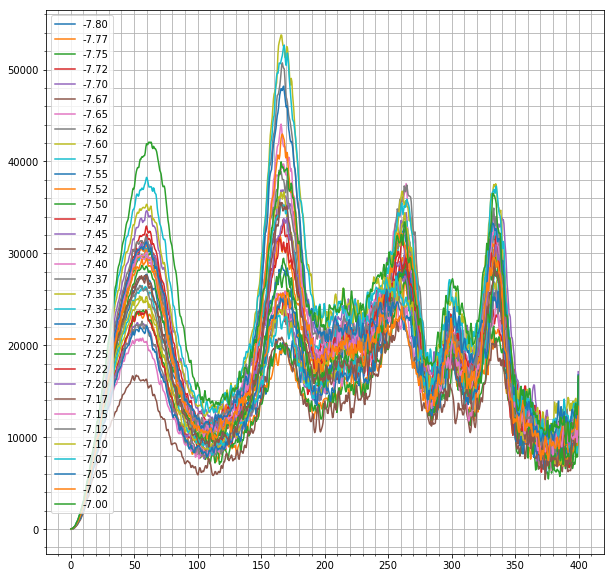

In [7]:
plt.figure(figsize=(10, 10))
for _, dt, dist in df[['delay', 'dist']].itertuples():
    plt.plot(r, dist, label=f"{dt:.2f}")
#     plt.plot(r**2, dist/2/r, label=f"{dt:.3f}")
plt.minorticks_on()
plt.grid(True, which='both')
plt.legend()
plt.show()

In [6]:
def intergrateit(dist, fr, to):
    where = (fr < r) & (r < to)
    return dist[where].sum()


df['summed1'] = df['dist'].apply(intergrateit, fr=0, to=100)
df['summed2'] = df['dist'].apply(intergrateit, fr=150, to=190)
df['summed3'] = df['dist'].apply(intergrateit, fr=200, to=230)
df['summed4'] = df['dist'].apply(intergrateit, fr=250, to=280)
df['summed5'] = df['dist'].apply(intergrateit, fr=280, to=320)
df['summed6'] = df['dist'].apply(intergrateit, fr=320, to=350)
df

,delay,df_img,df_n,dist,summed1,summed2,summed3,summed4,summed5,summed6
0,-7.80,"[[0.9626889998752404, 1.033177854064121, 0.923...",3227,"[2.0951666050193087, 16.29350315924788, 36.893...",3.195152e+06,1.439289e+06,1.047426e+06,1.507442e+06,1.411897e+06,1.241232e+06
1,-7.77,"[[0.6339993247061102, 0.7316705943964479, 0.68...",3249,"[2.0195843602925905, 15.74371437726097, 35.211...",2.736879e+06,1.323043e+06,9.190985e+05,1.322337e+06,1.179170e+06,1.047343e+06
2,-7.75,"[[0.8669001680100621, 1.1055979328662033, 0.63...",3295,"[1.574933955733223, 11.94481315470823, 27.1207...",2.752634e+06,1.369342e+06,8.924942e+05,1.329722e+06,1.153367e+06,1.029114e+06
3,-7.72,"[[0.8906436773348787, 0.9035684506616661, 0.69...",3295,"[1.7207278004257378, 14.802055306836376, 38.74...",2.779882e+06,1.597553e+06,1.028683e+06,1.542955e+06,1.282903e+06,1.133484e+06
4,-7.70,"[[0.869775893397943, 1.7640823743186047, 0.797...",3302,"[1.5749289565407547, 12.248257824553198, 28.41...",2.662676e+06,1.660355e+06,1.033494e+06,1.691602e+06,1.306801e+06,1.175755e+06
5,-7.67,"[[0.632289479472874, 0.7449557062011252, 0.431...",3165,"[0.9477344025096589, 7.096661172867179, 16.294...",1.985187e+06,1.379011e+06,8.213668e+05,1.450602e+06,1.039426e+06,9.752292e+05
6,-7.65,"[[0.8097643349223772, 0.9309836010226036, 0.75...",3291,"[1.8081344656021194, 14.353615864839279, 33.13...",2.476692e+06,1.679348e+06,1.037326e+06,1.813297e+06,1.261365e+06,1.168433e+06
7,-7.62,"[[0.755926993407229, 1.0810564413621933, 0.768...",3252,"[2.44240560469569, 18.022056388899884, 36.2390...",2.635649e+06,1.638247e+06,1.041529e+06,1.856526e+06,1.312738e+06,1.221124e+06
8,-7.60,"[[0.7969852366241379, 1.2441723879108333, 0.81...",6515,"[1.6974994225471267, 13.041800003613657, 29.83...",2.919144e+06,1.597805e+06,1.036776e+06,1.775569e+06,1.286612e+06,1.249321e+06
9,-7.57,"[[0.9362663532660491, 1.2410978035017308, 0.83...",3253,"[2.7261310441498985, 19.639019971474994, 38.09...",3.039423e+06,1.556599e+06,1.039867e+06,1.636452e+06,1.329120e+06,1.268481e+06


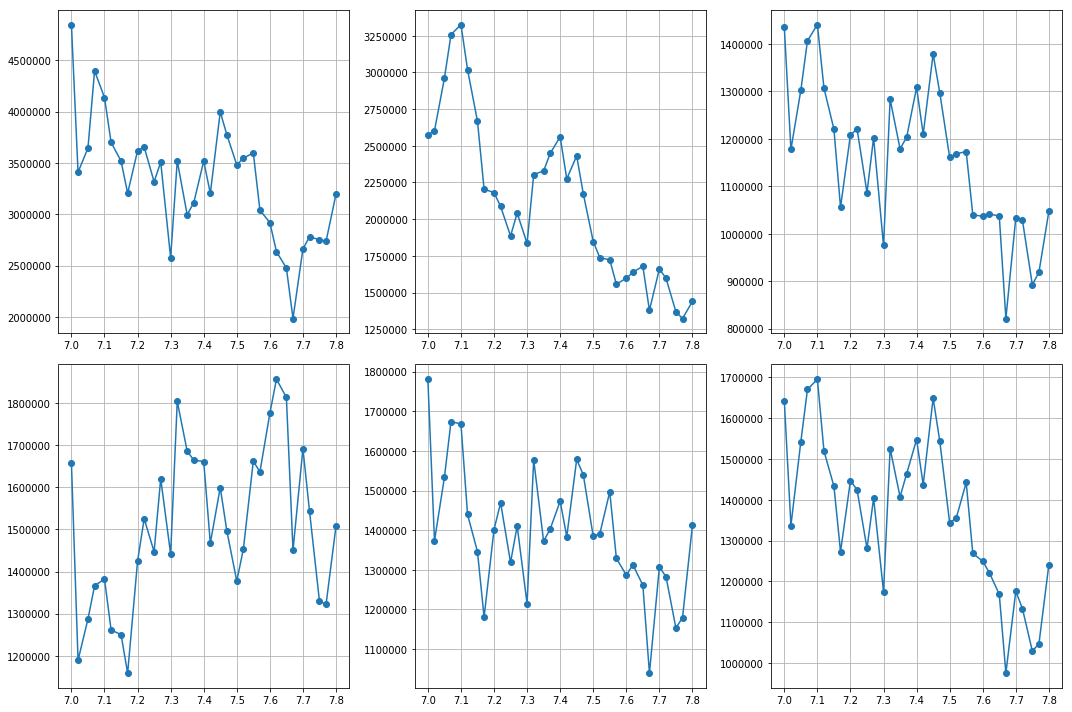

In [53]:
plt.figure(figsize=(15, 10))
for i in range(1, 7):
    plt.subplot(2, 3, i)
#     plt.title(f'{df["delay"]:.3f}')
    plt.plot(-df["delay"], df[f"summed{i}"], 'o-')
    plt.grid(True)
#     plt.ylim(0, None)
#     plt.axvline(7.1)
#     plt.axvline(7.1+0.235)
plt.tight_layout()
plt.show()